In [153]:
# Basics
import numpy as np
import pandas as pd
import os

# Scipy
from scipy import optimize
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import KDTree
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator, MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

def fmt(x, pos):
    ''' Used for the x10^ for colourbars'''
    if x == 0:
        return r'0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [154]:
def make_metals(clump):
    ''' Make extra columns on a given dataframe'''
    
    # Radius from the centre of the clump
    # Note: does not account for Z! (make a KDE later?)
    clump = clump.assign(r = np.power(np.power(clump.x_scale,2) + np.power(clump.y_scale,2) + np.power(clump.z_scale,2), 0.5))

    # Metals WITH HYDROGEN
    clump = clump.assign(m_H = clump.m_H + clump.m_He + clump.m_C + clump.m_N + clump.m_O + clump.m_Fe + \
                            clump.m_Mg + clump.m_Ca + clump.m_Si + clump.m_S + clump.m_Ba)
    
    # Metals WITHOUT HYDROGEN
    clump = clump.assign(m = clump.m_C + clump.m_N + clump.m_O + clump.m_Fe + \
                            clump.m_Mg + clump.m_Ca + clump.m_Si + clump.m_S + clump.m_Ba)

    # Dust
    clump = clump.assign(d_H = clump.d_H + clump.d_He + clump.d_C + clump.d_N + clump.d_O + clump.d_Fe + \
                            clump.d_Mg + clump.d_Ca + clump.d_Si + clump.d_S + clump.d_Ba)
    
    # Dust WITHOUT HYDROGEN
    clump = clump.assign(d = clump.d_C + clump.d_N + clump.d_O + clump.d_Fe + \
                            clump.d_Mg + clump.d_Ca + clump.d_Si + clump.d_S + clump.d_Ba)

    # Total z (need to account for solar metalicity)
    clump = clump.assign(z_metal = ((clump.m + clump.d)/(clump.m_H + clump.d_H))) # solar metalicity? only if you want Z/H
    #clump = clump.assign(z_metal = ((clump.m)/(clump.m_H)))
    
    # [Fe/H] calc
    clump = clump.assign(Fe_H = np.log10(clump.m_Fe/clump.m_H) - np.log10(0.00117/0.706) )
    #clump = clump.assign(Fe_H = np.log10((clump.m_Fe + clump.d_Fe)/(clump.m_H + clump.d_H) )- np.log10(0.00117/0.706) )
    
    clump = clump.assign(He_total = (clump.m_He + clump.d_H) /(clump.m_H + clump.d_H))
    
    # H2 mass of the clump (only relavent for the gas portion)
    clump = clump.assign(H2 = clump.mass * clump.frah)

    
    return clump

## Change which model you want to run here!

Update the ```model_to_analyse``` variable

In [582]:
model_to_analyse = 'gcmp38d'

model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/2_phase_sims/magellan3/" + model_to_analyse
os.chdir(model_path)

In [583]:
timesteps = np.load('timestep.npy')
if len(timesteps) == 3:
    no_of_steps = timesteps.size  # if no repeated time step
else:
    #no_of_steps = timesteps.size - 1 # take 1 if repeated final time step
    no_of_steps = timesteps.size

print('Timesteps of ', timesteps)

Timesteps of  [0.0000000e+00 7.0505499e+07 1.4100564e+08 2.1150564e+08 2.8200564e+08
 3.5250564e+08 3.5250564e+08]


In [584]:
col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'gid', 'mass', 'h', 'd', 'c', 'tt', 'frah', 
              'm_H', 'm_He', 'm_C', 'm_N', 'm_O', 'm_Fe', 'm_Mg', 'm_Ca', 'm_Si', 'm_S', 'm_Ba', 
              'd_H', 'd_He', 'd_C', 'd_N', 'd_O', 'd_Fe', 'd_Mg', 'd_Ca', 'd_Si', 'd_S', 'd_Ba', 'id']


df_g = [] # List of gas data frames
df_d = [] # List of disc stars data frames
df_n = [] # List of new stars data frames

for i in range(no_of_steps):

    df_g.append(pd.DataFrame(np.load('gas'+str(i)+'.npy'), columns=col_header))
    
    df_d.append(pd.DataFrame(np.load('gal'+str(i)+'.npy'), columns=col_header))
    
    # Caution for empty frames
    try: 
        df_n.append(pd.DataFrame(np.load('new'+str(i)+'.npy'), columns=col_header))
    except:
        df_n.append(-1)


In [585]:
path = "2_dispersion"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
    
    
os.chdir(path)
print('Current directory:', os.getcwd())

Creation of the directory 2_dispersion failed
Current directory: /Users/maddie/Desktop/Thesis/Simulation_output/2_phase_sims/magellan3/gcmp38d/2_dispersion


## Reading clump massess

In [626]:
os.chdir(model_path)
clump_summary = pd.read_csv("clump_masses.csv")
clump_summary = clump_summary.sort_values(by=['Gas_mass'], ascending=False)
clump_summary = clump_summary.assign(gas_new = clump_summary.Gas_mass+  clump_summary.New_mass)
os.chdir(path)
print(clump_summary)
print(clump_summary.shape)

    clump_id    Gas_mass  Disc_mass     New_mass        R_gal    Fe_H_g  \
2          2  36120600.0  1578825.0  1579211.000   174.642492 -0.947271   
5          5  17369100.0  1255500.0   321560.400  1461.677119 -1.183648   
0          0  15284700.0   451575.0   159473.200  1599.624956 -1.135690   
1          1  13003200.0   333450.0   106753.500  1535.610628 -1.165073   
3          3   8629200.0   298350.0    79405.090  1591.540135 -1.186400   
4          4   6933600.0   355050.0   164807.100   629.364759 -1.118623   
6          6   1638900.0    36450.0     3743.364   776.208735 -1.111480   
13        13    936900.0    16875.0     2507.598  1400.142850 -1.245546   
16        16    540000.0    19575.0     5014.266   545.893763 -1.214183   
12        12    507600.0     6750.0     1939.506  1364.441278 -1.247498   
11        11    491400.0     6750.0     2508.936  1629.294326 -1.358381   
9          9    475200.0    11475.0        0.000  1670.269439 -1.319693   
15        15    464400.0 

In [627]:
disc_mean = np.mean(np.asarray(clump_summary.Fe_H_d[clump_summary.Fe_H_d != ' nan'], float))
#np.asarray(clump_summary.Fe_H_d[clump_summary.Fe_H_d != ' nan'], float)

In [628]:
standard_err = clump_summary.sigma_Fe_H_g/np.sqrt(clump_summary.gas_count)
standard_err

2     0.000647
5     0.001470
0     0.001251
1     0.001301
3     0.001641
4     0.002023
6     0.002900
13    0.003403
16    0.004305
12    0.005399
11    0.005294
9     0.004301
15    0.004766
7     0.009476
14    0.003455
18    0.008187
21    0.004882
8     0.003404
19    0.005394
10    0.004067
20    0.009219
17    0.008219
dtype: float64

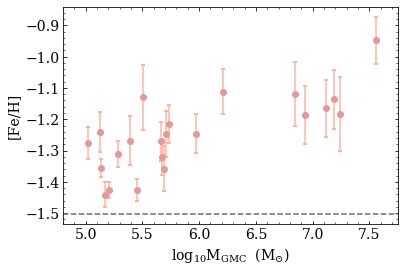

In [629]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
#plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
#fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g, yerr = clump_summary.sigma_Fe_H_g, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
plt.hlines(disc_mean, np.log10(min(clump_summary.Gas_mass))-0.5, np.log10(max(clump_summary.Gas_mass))+0.5, color = '#6D6875', linestyle= '--')
ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$\rm{log}_{10}\rm{M}_{\rm{GMC}} \ \ (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(4.8, 7.75)
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

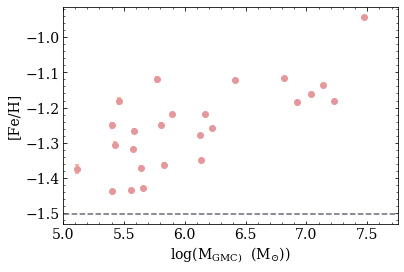

In [457]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
#plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
#fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g, yerr = standard_err, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
plt.hlines(disc_mean, np.log10(min(clump_summary.Gas_mass))-0.5, np.log10(max(clump_summary.Gas_mass))+0.5, color = '#6D6875', linestyle= '--')
ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$\rm{log(M}_{\rm{GMC})} \ \  (\rm{M}_{\odot}))$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(5, 7.75)
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

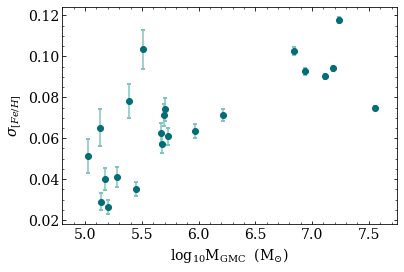

In [591]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
#plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
#fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.sigma_Fe_H_g, yerr = clump_summary.sigma_Fe_H_g/np.sqrt(clump_summary.gas_count), \
             fmt='o', capthick=2, ecolor='#83c5be', color = '#006d77', label = 'GMC')
#plt.hlines(disc_mean, np.log10(min(clump_summary.Gas_mass))-0.5, np.log10(max(clump_summary.Gas_mass))+0.5, color = '#6D6875', linestyle= '--')
ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
ax.set_xlabel(r'$\rm{log}_{10}\rm{M}_{\rm{GMC}} \ \ (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(4.8, 7.75)
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.savefig("fe_spread_sigma", bbox_inches='tight', dpi = 300)
plt.show()

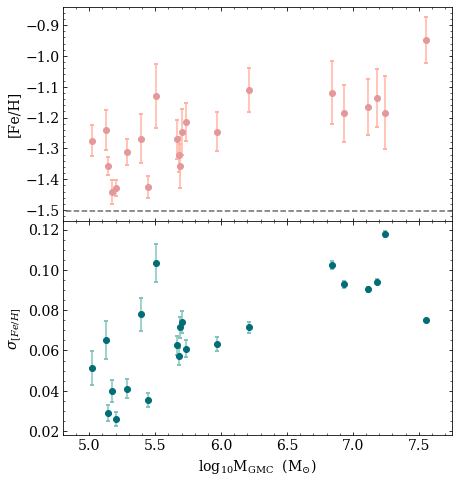

In [646]:
fig = plt.figure()
fig.set_size_inches(6,7)
gs = fig.add_gridspec(2,1)  


ax = plt.subplot(gs[0,0]) # top 
ax1 = plt.subplot(gs[1,0], sharex = ax) # bottom

plt.setp(ax.get_xticklabels(), visible=False)

#plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
#fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
ax.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g, yerr = clump_summary.sigma_Fe_H_g, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
ax.hlines(disc_mean, np.log10(min(clump_summary.Gas_mass))-0.5, np.log10(max(clump_summary.Gas_mass))+0.5, color = '#6D6875', linestyle= '--')
ax.set_ylabel(r'[Fe/H]')
#ax.set_xlabel(r'$\rm{log}_{10}\rm{M}_{\rm{GMC}} \ \ (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax1.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.sigma_Fe_H_g, yerr = clump_summary.sigma_Fe_H_g/np.sqrt(clump_summary.gas_count), \
             fmt='o', capthick=2, ecolor='#83c5be', color = '#006d77', label = 'GMC')
ax1.set_ylabel(r'$\sigma_{[Fe/H]}$')
ax1.set_xlabel(r'$\rm{log}_{10}\rm{M}_{\rm{GMC}} \ \ (\rm{M}_{\odot})$')
ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim(4.8, 7.75)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.0, hspace=0.0)   


#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.savefig("fe_spread_2_subplots", bbox_inches='tight', dpi = 300)
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
#plt.errorbar(np.log10(clump_summary.Disc_mass), clump_summary.Fe_H_d, yerr = clump_summary.sigma_Fe_H_d, \
#fmt='o', capthick=2, ecolor='#B5838D', color = '#6D6875', label = 'Disc')
plt.errorbar(np.log10(clump_summary.Gas_mass), clump_summary.Fe_H_g, yerr = clump_summary.sigma_Fe_H_g, \
             fmt='o', capthick=2, ecolor='#FFB4A2', color = '#E5989B', label = 'GMC')
ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

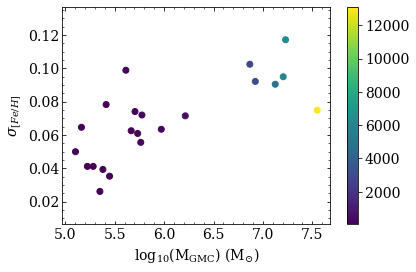

In [375]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(np.log10(clump_summary.Gas_mass), clump_summary.sigma_Fe_H_g, c=clump_summary.gas_count, label = 'GMC')
ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.colorbar()
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

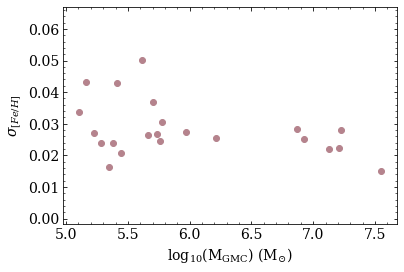

In [356]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(np.log10(clump_summary.Gas_mass), clump_summary.sigma_Fe_H_g/np.sqrt(clump_summary.gas_count), color='#B5838D', label = 'GMC')
ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

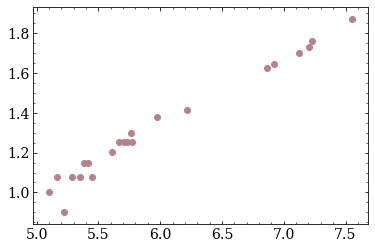

In [322]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(np.log10(clump_summary.Gas_mass), np.log10(clump_summary.crop_radii), color='#B5838D', label = 'GMC')
#ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
#ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

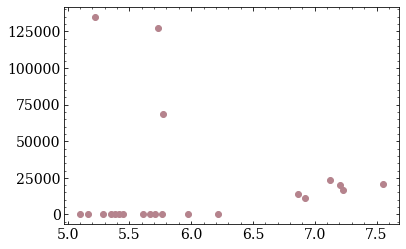

In [380]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(np.log10(clump_summary.Gas_mass), clump_summary.g_temperature, color='#B5838D', label = 'GMC')
#ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
#ax.set_xlabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

0.49898430240154557 -2.3059582677246047


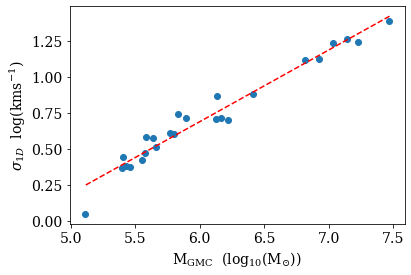

In [401]:
x = np.log10(clump_summary.Gas_mass)
y = np.log10(clump_summary.v_disp)

def give_me_a_straight_line(x,y):
    w, b  = np.polyfit(x,y,deg=1)
    line  = w * x + b
    
    print(w, b)
    return line

line = give_me_a_straight_line(x,y)

plt.plot(x,y,'o')
plt.plot(x,line,'r--')
plt.ylabel(r'$\sigma_{1D} \ \ \rm{log}(kms^{-1})$')
plt.xlabel(r'$\rm{M}_{\rm{GMC}} \ \ (\rm{log}_{10} (\rm{M}_{\odot}))$')
plt.show()

1.114500361566001 -0.6982150443884448


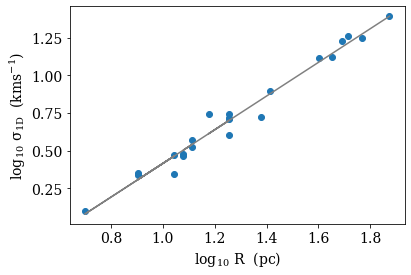

In [594]:
x = np.log10(clump_summary.crop_radii)
y = np.log10(clump_summary.v_disp)
#y = np.log10(std_val)

line = give_me_a_straight_line(x,y)

plt.plot(x,y,'o')
plt.plot(x,line, color = 'grey')
plt.xlabel(r'$\rm{log}_{10} \ R \ \ (pc)$')
plt.ylabel(r'$\rm{log}_{10}\ \sigma_{1D} \ \ (kms^{-1})$')
plt.show()

In [ ]:
x = np.log10(clump_summary.crop_radii)
y = np.log10(clump_summary.Gas_mass)
#y = np.log10(std_val)

line = give_me_a_straight_line(x,y)

plt.plot(x,y,'o')
plt.plot(x,line,'r--')
plt.xlabel(r'radii $ \rm{log}(pc)$')
plt.ylabel(r'$\rm{M}_{\rm{GMC}} \ \ (\rm{log}_{10} (\rm{M}_{\odot}))$')
plt.show()

In [ ]:
x = np.log10(clump_summary.crop_radii)
y = np.log10(clump_summary.v_disp)
#y = np.log10(std_val)

line = give_me_a_straight_line(x,y)

plt.plot(x,y,'o')
plt.plot(x,line,'r--')
plt.ylabel(r'$\sigma_{1D} \ \ \rm{log}(kms^{-1})$')
plt.xlabel(r'radii $ \rm{log}(pc)$')
plt.show()

2.482994829341343 2.7555486852797757


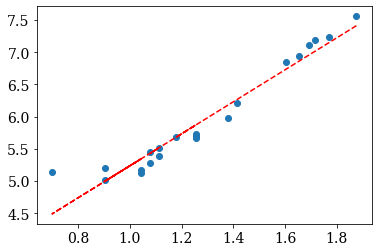

In [593]:
y = np.log10(clump_summary.Gas_mass)
x = np.log10(clump_summary.crop_radii)
line = give_me_a_straight_line(x,y)

plt.plot(x,y,'o')
plt.plot(x,line,'r--')


In [592]:
# surface density should be constant?
clump_summary.Gas_mass/(np.pi*(clump_summary.crop_radii)**2)

2     2044.007836
5     1588.266660
0     1799.286656
1     1723.884678
3     1356.424528
4     1379.395892
6      771.713125
13     517.750924
16     530.516477
12     498.685488
11     695.188791
9      466.854500
15     456.244170
7      605.165482
14     620.704278
18     462.773604
21     423.750036
8      792.293201
19     390.653042
10    1753.250853
20     355.139129
17     523.719235
dtype: float64

In [319]:
G = 4.3e-3
std_val = np.sqrt(2*G*clump_summary.Gas_mass/clump_summary.crop_radii)

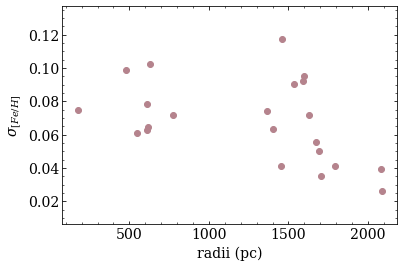

In [316]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
plt.scatter(clump_summary.R_gal, clump_summary.sigma_Fe_H_g, color='#B5838D', label = 'GMC')
ax.set_ylabel(r'$\sigma_{[Fe/H]}$')
ax.set_xlabel(r'radii (pc)')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_title('Clump Spread')
#plt.savefig("fe_spread_vs_mass", bbox_inches='tight', dpi = 300)
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
#             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
#plt.savefig("fe_spread_HMR", bbox_inches='tight', dpi = 300)
plt.show()

## Reading Central location values

In [470]:
os.chdir(model_path)
m = pd.read_csv("centre_loc.csv")
os.chdir(path)
print(m)
print(m.shape)

    clump_id           x            y          z
0          0  1170.08750  1075.680750   2.608402
1          1 -1337.26700  -758.119000   2.407725
2          2   -75.86110  -163.698400  -3.085350
3          3    66.16435 -1602.105500 -16.124575
4          4   586.95225   177.707000   1.131275
5          5  1448.79775    57.518125  -6.085050
6          6   188.28500   745.372000  21.695550
7          7  -508.25575   -53.631975  -0.717450
8          8  1322.71300 -1614.296250  28.626125
9          9  1650.41000    50.862235  34.680375
10        10  -390.18400  1399.009500  32.623125
11        11   846.01925 -1381.319500   7.327375
12        12 -1371.70375  -109.346275  -3.391075
13        13 -1003.57800   963.571000  33.002925
14        14  -887.33275 -1462.890500   2.562925
15        15  -619.23725    54.434675 -35.614325
16        16   531.79150   -86.316425 -74.514650
17        17  -142.08385   274.535000  -6.978575
18        18 -1535.90400  -736.103750 -14.213225
19        19  -554.8

# Getting clumps

CLUMP:  2


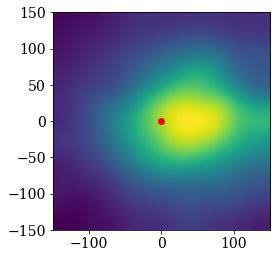

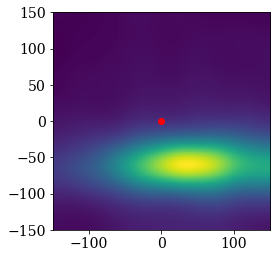

x pos, y pos:  37 -1
x pos, z pos:  34 -60
y pos, z pos:  -2 -62


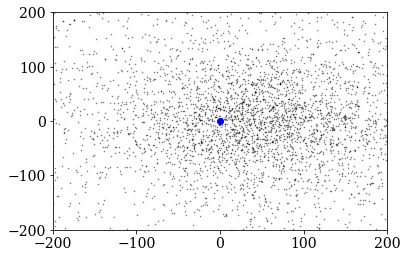

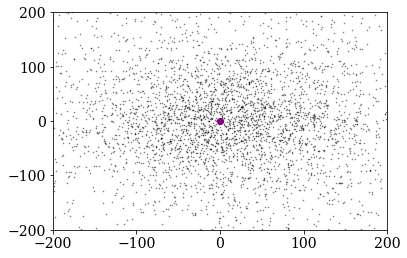

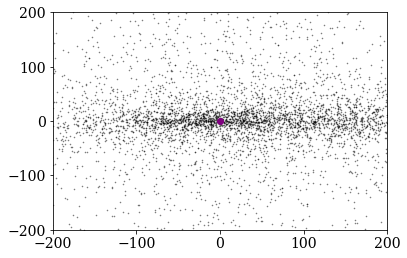

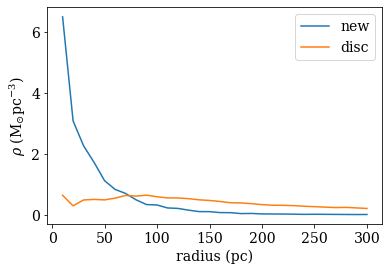

sigma < limit 0.4719909351530727
disc dispersion is:  49.98926447413651


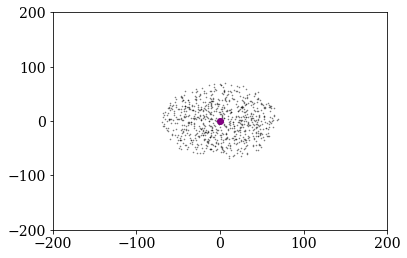

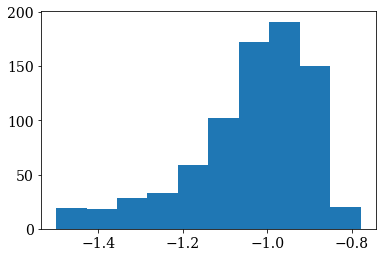

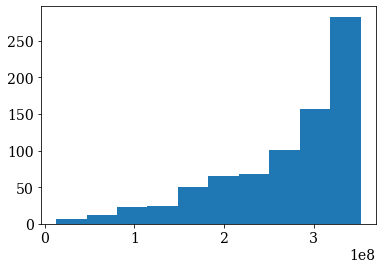

CLUMP:  5


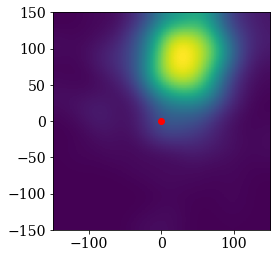

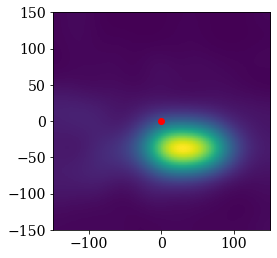

x pos, y pos:  28 88
x pos, z pos:  28 -38
y pos, z pos:  101 -40


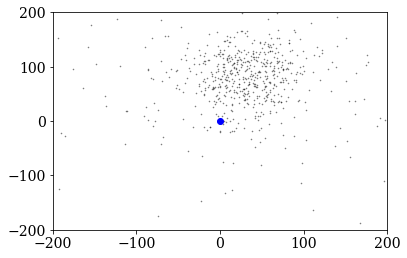

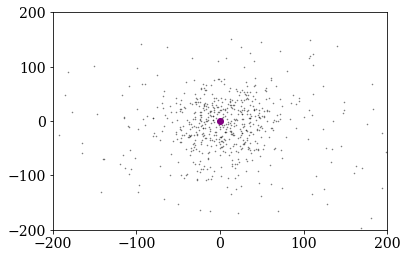

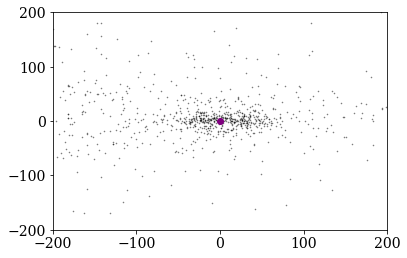

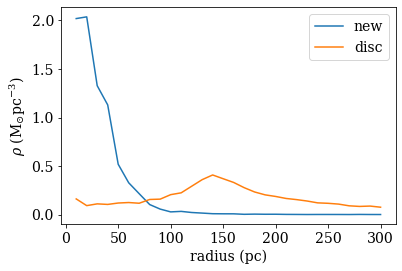

sigma < limit 0.4719909351530727
disc dispersion is:  23.11412718166313


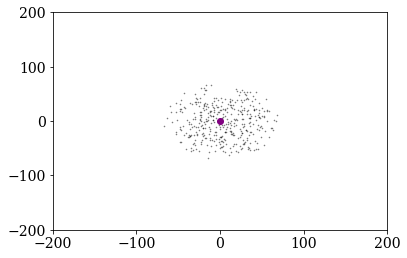

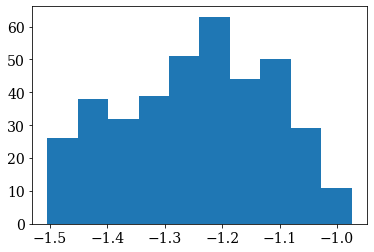

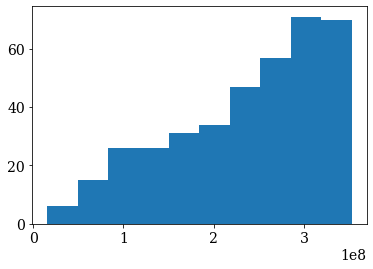

CLUMP:  0


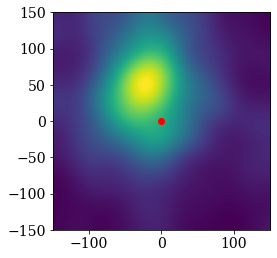

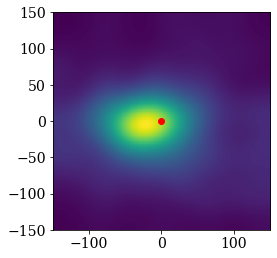

x pos, y pos:  -23 50
x pos, z pos:  -23 -5
y pos, z pos:  41 -4


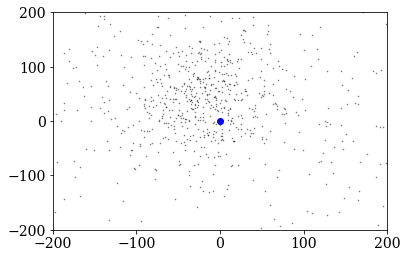

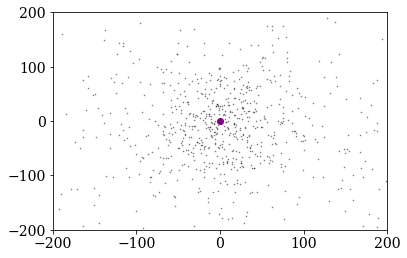

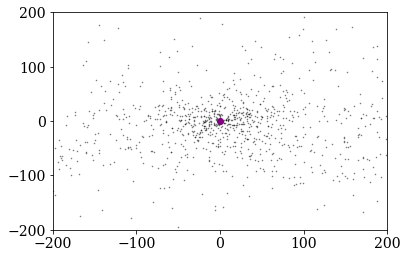

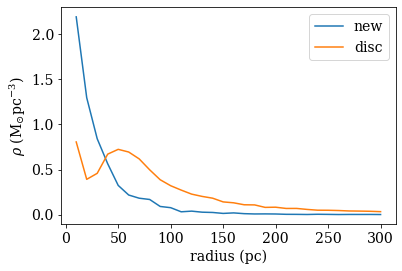

sigma < limit 0.4719909351530727
disc dispersion is:  26.368987881700143


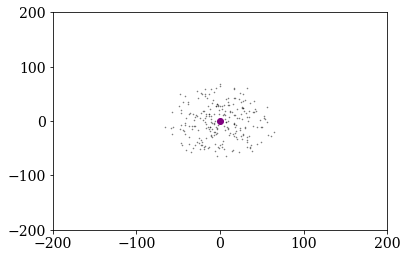

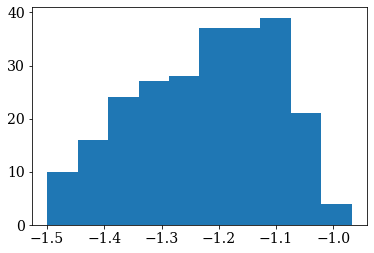

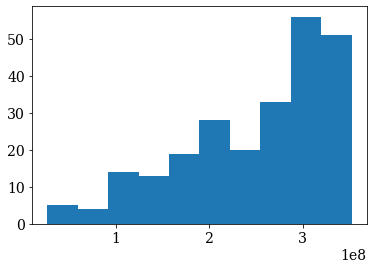

CLUMP:  1


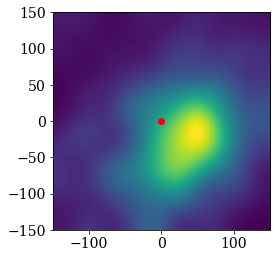

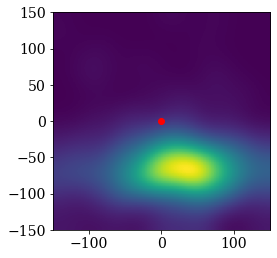

x pos, y pos:  47 -16
x pos, z pos:  34 -66
y pos, z pos:  -19 -67


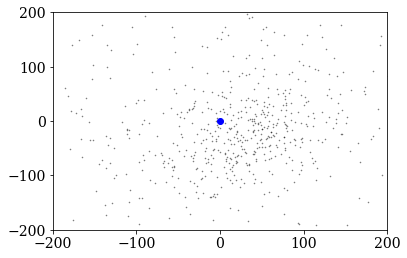

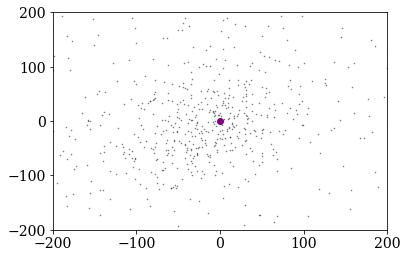

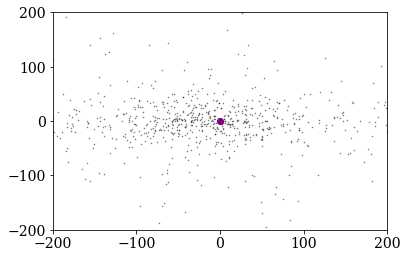

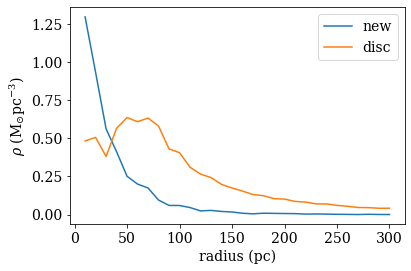

sigma < limit 0.4719909351530727
disc dispersion is:  24.639575391257267


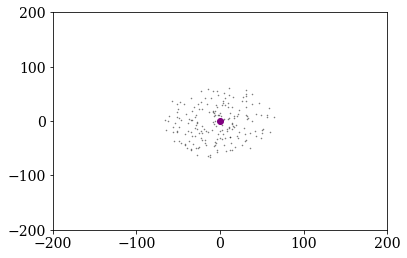

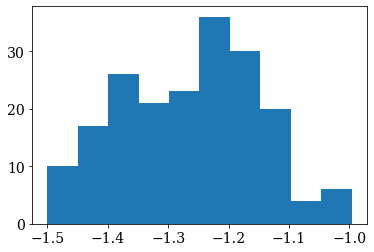

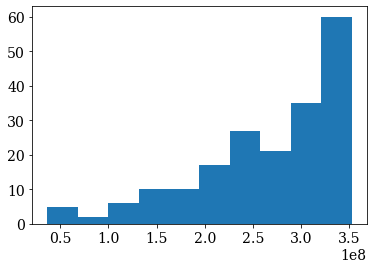

CLUMP:  3


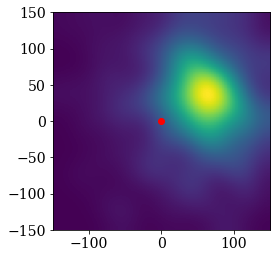

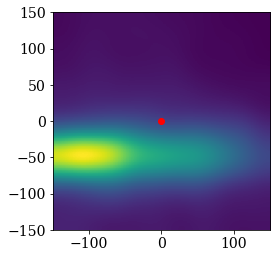

x pos, y pos:  62 36
x pos, z pos:  -109 -47
y pos, z pos:  31 -57


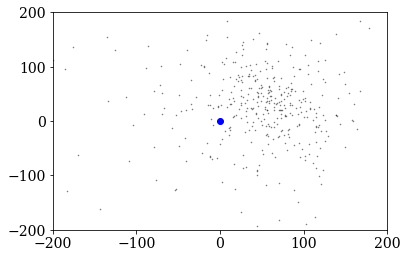

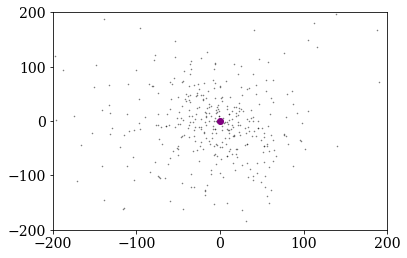

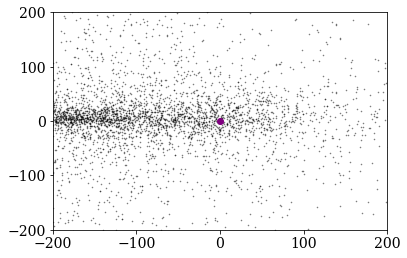

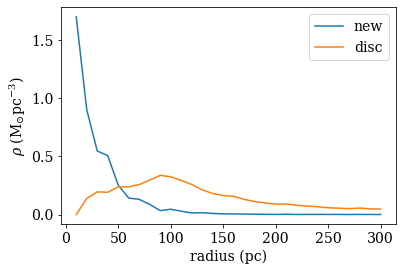

sigma < limit 0.4719909351530727
disc dispersion is:  17.877128094839147


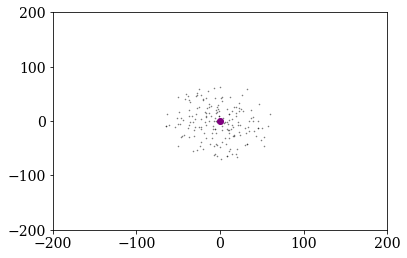

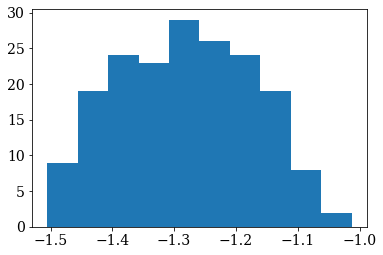

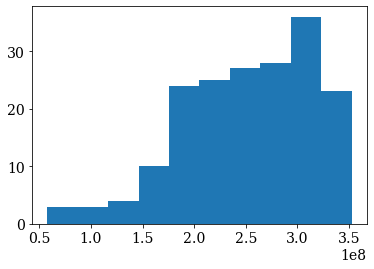

CLUMP:  4


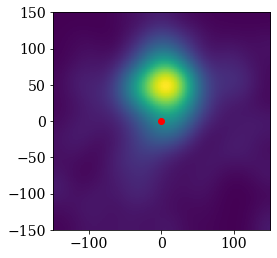

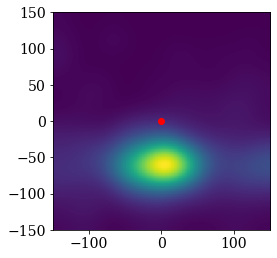

x pos, y pos:  5 48
x pos, z pos:  3 -61
y pos, z pos:  -19 -47


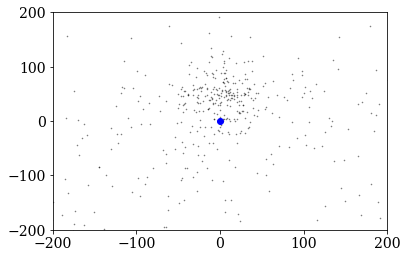

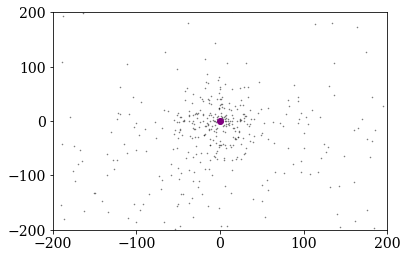

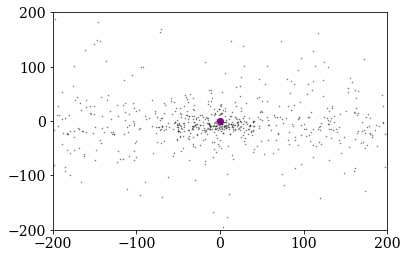

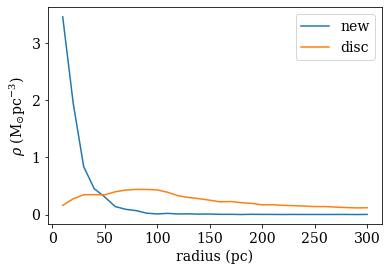

sigma < limit 0.4719909351530727
disc dispersion is:  23.80969283458576


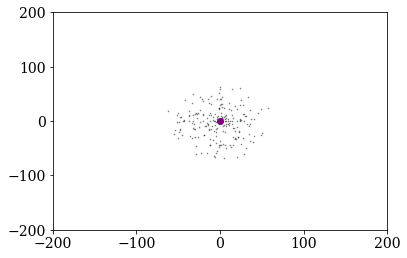

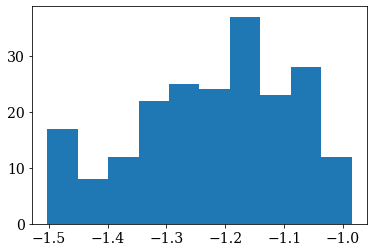

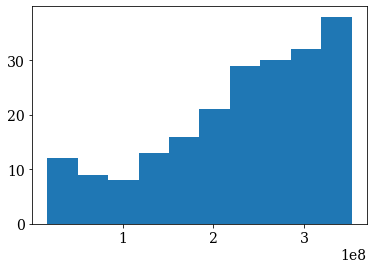

CLUMP:  6


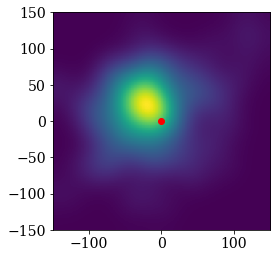

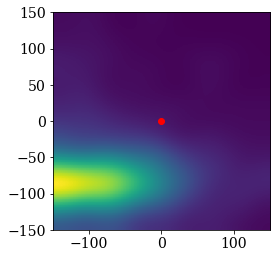

x pos, y pos:  -21 22
x pos, z pos:  -150 -86
y pos, z pos:  19 -63


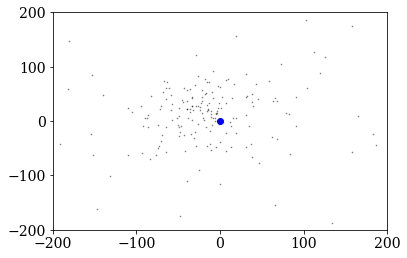

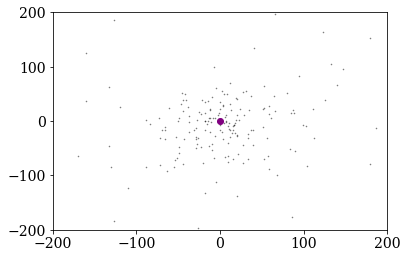

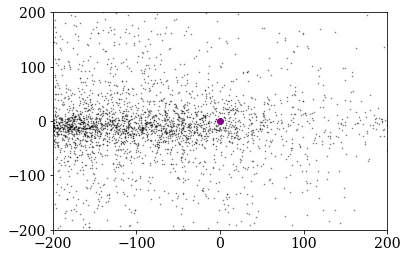

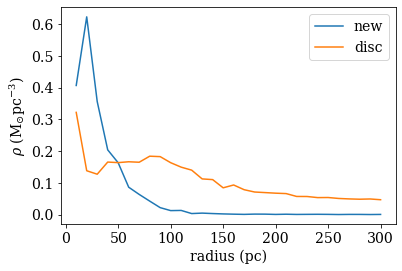

sigma < limit 0.4719909351530727
disc dispersion is:  14.293000550630302


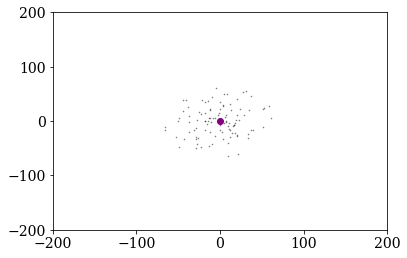

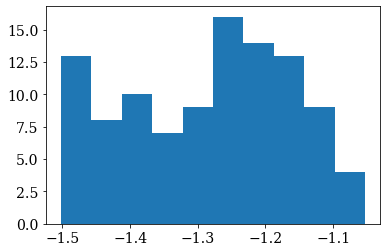

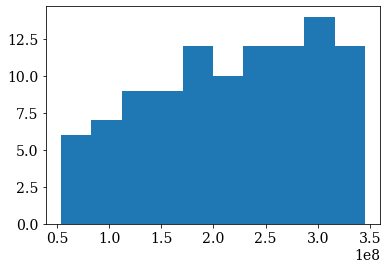

CLUMP:  13


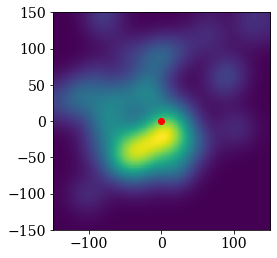

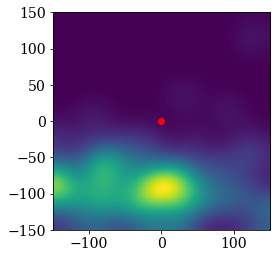

x pos, y pos:  -1 -23
x pos, z pos:  1 -93
y pos, z pos:  149 -34


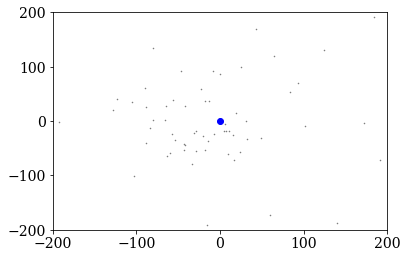

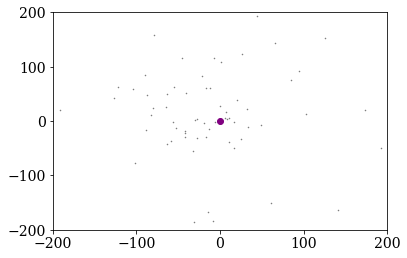

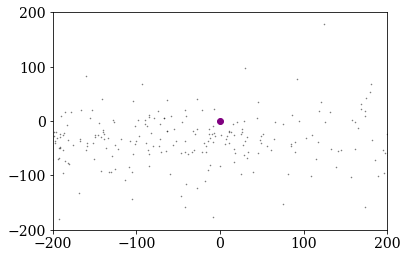

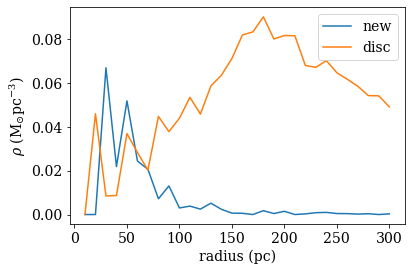

sigma < limit 0.4719909351530727
disc dispersion is:  12.136343992143022


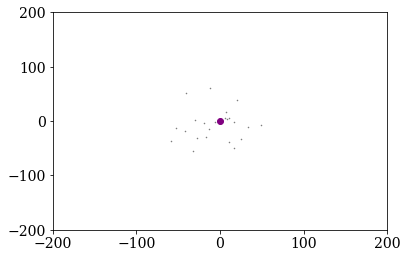

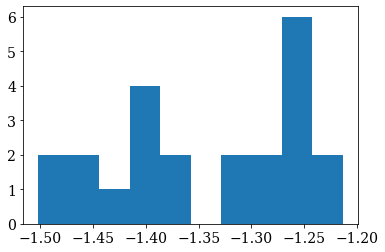

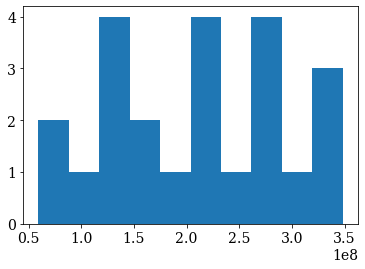

In [605]:
disc_disp_arr = []
new_disp_arr = []
offset = []
new_mass = []
disc_mass = []
#for j in range(m.shape[0]):
for j in [2,5,0,1,3,4,6,13]:
#for j in range(2):
    print('CLUMP: ', j)
    #plot positin
    rng = 150
    bns = 2*rng
    clump_meanXY, _, _,_ = stats.binned_statistic_2d(df_n[-1].x - m.x[j], df_n[-1].y -  m.y[j], 
                                               values = df_n[-1].mass, statistic ='sum', bins = bns, range = [[-rng, rng], [-rng, rng]])
    
    clump_meanXZ, _, _,_ = stats.binned_statistic_2d(df_n[-1].x - m.x[j], df_n[-1].z -  m.z[j], 
                                               values = df_n[-1].mass, statistic ='sum', bins = bns, range = [[-rng, rng], [-rng, rng]])
    
    clump_meanYZ, _, _,_ = stats.binned_statistic_2d(df_n[-1].y - m.y[j], df_n[-1].z -  m.z[j], 
                                               values = df_n[-1].mass, statistic ='sum', bins = bns, range = [[-rng, rng], [-rng, rng]])
    
    clump_meanXY = gaussian_filter(clump_meanXY, sigma=20)
    clump_meanXZ = gaussian_filter(clump_meanXZ, sigma=20)
    clump_meanYZ = gaussian_filter(clump_meanYZ, sigma=20)
    
    # current centering
    fig, ax = plt.subplots()
    im1 = ax.imshow(clump_meanXY.T, origin='lower', extent=[-rng, rng, -rng, rng])
    ax.scatter(0,0, color='red')
    plt.show()
     # current centering
    fig, ax = plt.subplots()
    im1 = ax.imshow(clump_meanXZ.T, origin='lower', extent=[-rng, rng, -rng, rng])
    ax.scatter(0,0, color='red')
    plt.show()
   

    max_result_XY = np.where(clump_meanXY == np.amax(clump_meanXY))
    max_x_m = max_result_XY[0][0]
    max_y_m = max_result_XY[1][0]
    
    
    # subtract imshow offset
    max_x_m -=rng
    max_y_m -=rng
    
    print("x pos, y pos: ", max_x_m, max_y_m)
    
    
    max_result_XZ = np.where(clump_meanXZ == np.amax(clump_meanXZ))
    max_x_m_other = max_result_XZ[0][0]
    max_z_m = max_result_XZ[1][0]
    
    # subtract imshow offset
    max_x_m_other -=rng
    max_z_m -=rng
    
    print("x pos, z pos: ", max_x_m_other, max_z_m)
    
    
    max_result_YZ = np.where(clump_meanYZ == np.amax(clump_meanYZ))
    max_y_m_other = max_result_YZ[0][0]
    max_z_m_other = max_result_YZ[1][0]
    
    # subtract imshow offset
    max_y_m_other -=rng
    max_z_m_other -=rng
    
    print("y pos, z pos: ", max_y_m_other, max_z_m_other)
    
    max_x_avg = (max_x_m + max_x_m_other)/2
    max_y_avg = (max_y_m + max_y_m_other)/2
    max_z_avg = (max_z_m + max_z_m_other)/2
    
    offset.append(np.sqrt(max_x_m**2 + max_y_m**2 + max_z_avg**2))
    
    
    fig, ax = plt.subplots()
    plt.scatter(df_n[-1].x -  m.x[j], df_n[-1].y -  m.y[j], color = 'black', alpha = 0.5, s = 0.3)
    plt.scatter(0,0, color='blue')
    plt.xlim(-scatter_lim,scatter_lim)
    plt.ylim(-scatter_lim,scatter_lim)
    plt.show()
    
    
    scatter_lim = 200
    # confirm correct scaling
    fig, ax = plt.subplots()
    plt.scatter(df_n[-1].x -  m.x[j] - max_x_m, df_n[-1].y -  m.y[j] - max_y_m, color = 'black', alpha = 0.5, s = 0.3)
    plt.scatter(0,0, color='purple')
    plt.xlim(-scatter_lim,scatter_lim)
    plt.ylim(-scatter_lim,scatter_lim)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.scatter(df_n[-1].x -  m.x[j] - max_x_m, df_n[-1].z -  m.z[j] - max_z_avg, color = 'black', alpha = 0.5, s = 0.3)
    plt.scatter(0,0, color='purple')
    plt.xlim(-scatter_lim,scatter_lim)
    plt.ylim(-scatter_lim,scatter_lim)
    plt.show()
    
    # Scale n
    n_clump = n_clump.assign(x_scale = df_n[-1].x -  m.x[j] - max_x_m)
    n_clump = n_clump.assign(y_scale = df_n[-1].y -  m.y[j] - max_y_m)
    n_clump = n_clump.assign(z_scale = df_n[-1].z -  m.z[j] - max_z_avg)
    n_clump = n_clump.assign(r = (n_clump.x_scale**2 + n_clump.y_scale**2 + n_clump.z_scale**2)**0.5)
    
    # Scale d
    d_clump = d_clump.assign(x_scale = df_d[-1].x -  m.x[j] - max_x_m)
    d_clump = d_clump.assign(y_scale = df_d[-1].y -  m.y[j] - max_y_m)
    d_clump = d_clump.assign(z_scale = df_d[-1].z -  m.z[j] - max_y_avg)
    d_clump = d_clump.assign(r = (d_clump.x_scale**2 + d_clump.y_scale**2 + d_clump.z_scale**2)**0.5)
    
    # Volume calcs
    max_r = 300

    bin_sums_n, bin_edges, binnumber = stats.binned_statistic(n_clump.r, n_clump.mass, statistic='sum', bins=int(max_r/10), range = [0,max_r])
    bin_sums_d, bin_edges, binnumber = stats.binned_statistic(d_clump.r, d_clump.mass, statistic='sum', bins=int(max_r/10), range = [0,max_r])

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2


    volume = (4/3) * np.pi * bin_edges**3
    volume_differences = volume[1:] - volume[:-1]
    sigma_n = bin_sums_n/volume_differences
    sigma_d = bin_sums_d/volume_differences
    
    
    
    
    fig, ax  = plt.subplots()
    plt.plot(bin_edges[1:], sigma_n, label = r'new')
    plt.plot(bin_edges[1:], sigma_d,  label = r'disc')
    ax.set_ylabel(r'$\rho \  (\rm{M}_{\odot}pc^{-3})$')
    ax.set_xlabel('radius (pc)')
    plt.legend()
    plt.show()
    
    # Crops
    i = 100
    '''d_clump_crop =  d_clump.loc[(d_clump.y_scale<i)&(d_clump.y_scale>-i)& \
                               (d_clump.x_scale<i)&(d_clump.x_scale>-i)& \
                               (d_clump.z_scale<i)&(d_clump.z_scale>-i)]

    n_clump_crop =  n_clump.loc[(n_clump.y_scale<i)&(n_clump.y_scale>-i)& \
                               (n_clump.x_scale<i)&(n_clump.x_scale>-i)& \
                               (n_clump.z_scale<i)&(n_clump.z_scale>-i)]'''
    
    limit = 0.5
    
    # Return as soon as you find a density less than 1 Msun pc^3
    for i in range(5,len(sigma)):

        # Find density threshold
        if sigma[i] < limit: 
            print('sigma < limit', sigma[i])
            # return radius of where that density limit occurs
            i = r[i]
            break
    
    
    d_clump_crop =  d_clump.loc[(d_clump.r<i)]
    n_clump_crop =  n_clump.loc[(n_clump.r<i)]
    
    new_mass.append(np.sum(n_clump_crop.mass))
    disc_mass.append(np.sum(d_clump_crop.mass))
    
    disc__disp = ((np.std(d_clump_crop.vx)**2 + np.std(d_clump_crop.vy)**2 + np.std(d_clump_crop.vz)**2)**0.5 )/(3**0.5)
    new__disp = ((np.std(n_clump_crop.vx)**2 + np.std(n_clump_crop.vy)**2 + np.std(n_clump_crop.vz)**2)**0.5 )/(3**0.5)
    print('disc dispersion is: ', disc__disp)
    disc_disp_arr.append(disc__disp)
    new_disp_arr.append(new__disp)
    
    fig, ax = plt.subplots()
    plt.scatter(n_clump_crop.x_scale, n_clump_crop.y_scale, color = 'black', alpha = 0.5, s = 0.3)
    plt.scatter(0,0, color='purple')
    plt.xlim(-scatter_lim,scatter_lim)
    plt.ylim(-scatter_lim,scatter_lim)
    plt.show()
    
    # New star metals
    n_clump_crop = make_metals(n_clump_crop)
    fig, ax = plt.subplots()
    plt.hist(n_clump_crop.Fe_H)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.hist(n_clump_crop.tt)
    plt.show()

In [568]:
merged_disc = d_clump_crop.merge(df_d[3], on='id')
merged_new = n_clump_crop.merge(df_n[3], on='id')

(0, 1000)

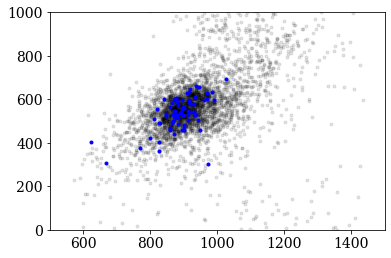

In [612]:
#plt.plot(df_d[3].x, df_d[3].y, 'r.', alpha = 0.01)
plt.plot(merged_disc.x_y, merged_disc.y_y, 'k.', alpha = 0.1)
plt.plot(merged_new.x_y, merged_new.y_y, 'b.')
#plt.plot(df_g[3].x, df_g[3].y, 'g.', alpha = 0.01)
plt.xlim(500,1500)
plt.ylim(0,1000)